<a href="https://colab.research.google.com/github/phutdi/HW/blob/master/StockPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install pandas-datareader

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib as mtl
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 1, 9)

df = web.DataReader("BA", 'yahoo', start, end)
df.tail()

dfl = web.DataReader("^GSPC", 'yahoo', start, end)
dfl.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-03,2493.139893,2443.959961,2491.919922,2447.889893,3822860000,2447.889893
2019-01-04,2538.070068,2474.330078,2474.330078,2531.939941,4213410000,2531.939941
2019-01-07,2566.159912,2524.560059,2535.610107,2549.689941,4104710000,2549.689941
2019-01-08,2579.820068,2547.560059,2568.110107,2574.409912,4083030000,2574.409912
2019-01-09,2595.320068,2568.889893,2580.000000,2584.959961,4052480000,2584.959961


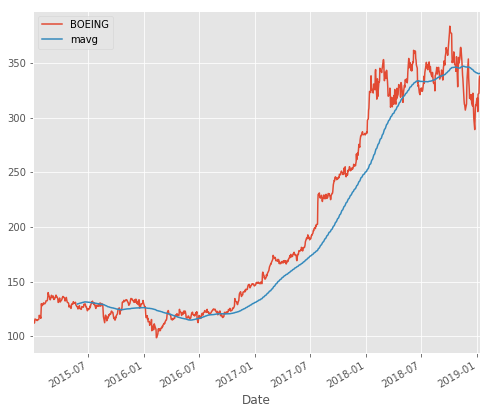

In [15]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='BOEING')
mavg.plot(label='mavg')
plt.legend()

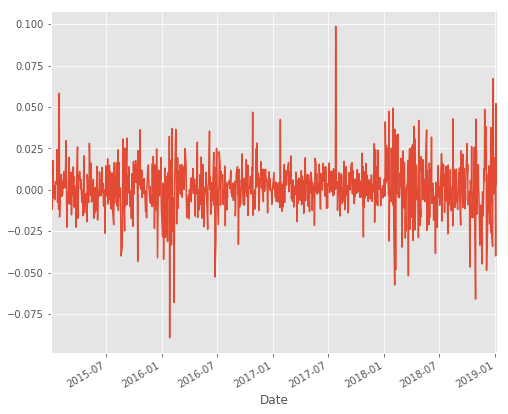

In [16]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')


In [0]:
dfcomp = web.DataReader(['BA', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

Text(0, 0.5, 'IBM')

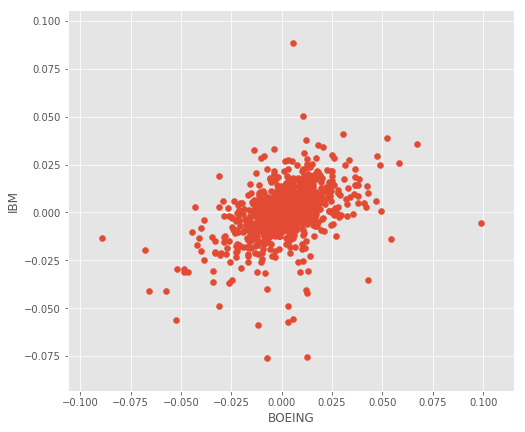

In [18]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
plt.scatter(retscomp.BA, retscomp.IBM)
plt.xlabel("BOEING")
plt.ylabel("IBM")

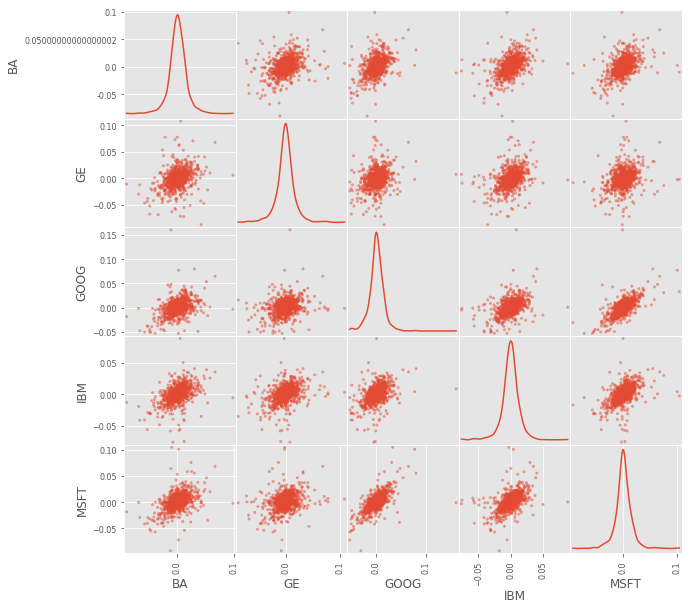

In [19]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

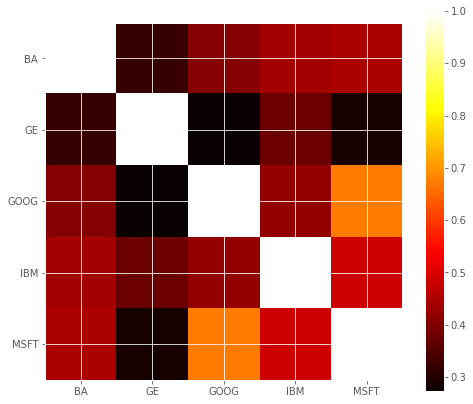

In [20]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

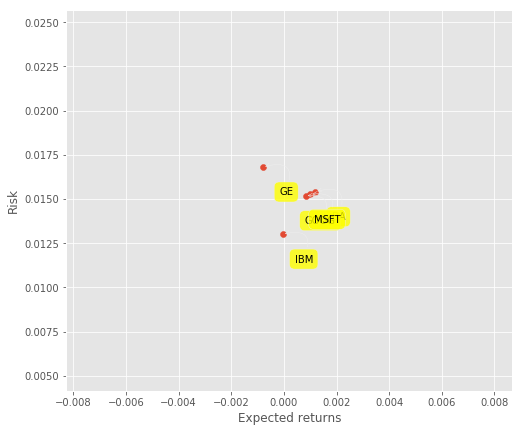

In [21]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (30, -30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.8),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=1'))

In [0]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0

In [23]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-01-03,305.671448,5705600.0,3.325827,-2.688659
2019-01-04,321.579346,4448800.0,3.778897,3.280806
2019-01-07,322.591980,4030300.0,2.237054,-0.729155
2019-01-08,334.803162,4736500.0,2.525477,1.921527
2019-01-09,338.047638,4213900.0,1.841031,0.253672


In [24]:
from sklearn import preprocessing, model_selection, svm

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

# Separation of training and testing of model by cross validation train test split
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)



(1012, 4)
Dimension of X (1001, 4)
Dimension of y (1001,)


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [26]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9882622627678863
The quadratic regression 2 confidence is  0.9891648868291294
The quadratic regression 3 confidence is  0.9898784690597827
The knn regression confidence is  0.9792217126922604


[290.86288675 307.63289971 311.65208105 312.18099901 317.69913013
 318.41450439 307.00166244 321.16644636 323.4563109  334.67417934
 338.46919647] 0.9882622627678863 11


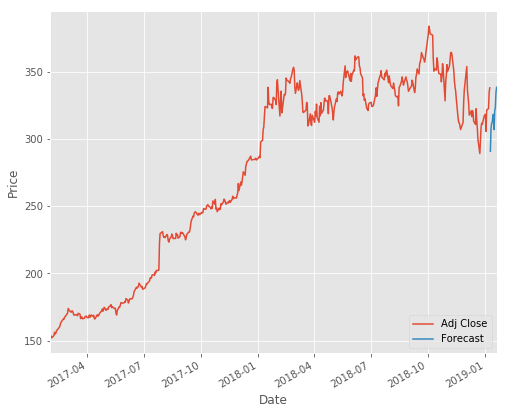

In [27]:
# Printing the forecast from liner regression
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidencereg, forecast_out)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


[295.7545113  310.48192257 311.57575105 314.32811969 319.17237281
 318.58950775 311.1901219  321.6057902  323.315846   332.48581022
 335.69447016] 0.9891648868291294 11


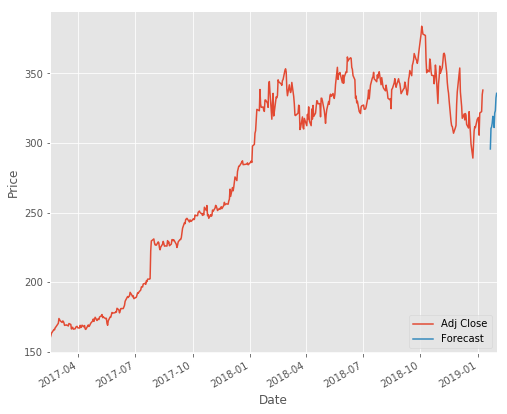

In [28]:
# Printing the forecast from liner regression2
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidencepoly2, forecast_out)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

[309.36462402 328.35346985 311.01994324 330.51539612 317.29507446
 353.41978455 335.03213501 336.47026062 326.31323242 316.11282349
 348.76409912] 0.9792217126922604 11


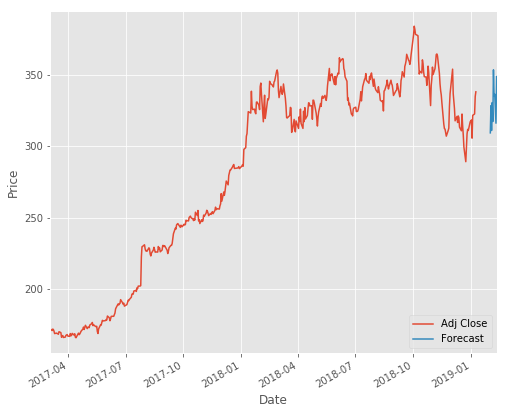

In [29]:
# Printing the forecast from liner KNN
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidenceknn, forecast_out)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]


dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()